# @WeRateDogs project: Data Wrangling

## Table of Contents

- [Gather](#gather)
- [Assess](#assess)
- [Clean](#clean)
- [Storing, analyzing, and visualizing](#story)

<a id='gather'></a>
## Gather

In [1]:
import pandas as pd
import numpy as np
import zipfile
import requests
from bs4 import BeautifulSoup
import os
import glob
import tweepy
import json
from PIL import Image
from timeit import default_timer as timer
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**1. Read given file twitter-archive-enhanced.csv and load it to a dataframe**

In [2]:
# Read given CSV (comma-separated) file and save it in a dataframe
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,8.924206e+17,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,8.921774e+17,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,8.918152e+17,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,8.916896e+17,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,8.913276e+17,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
df_twitter_archive.tweet_id = df_twitter_archive.tweet_id.astype(int)

In [4]:
df_twitter_archive.shape

(2356, 17)

**2. Download file image_predictions.tsv programatically and stored it in a dataframe**

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [6]:
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

In [7]:
df_image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [8]:
df_image_predictions.shape

(2075, 12)

**3.  Create file  tweet_json.txt with data from Twitter API**

In [9]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
consumer_key = 'XXXXXXXXXX'
consumer_secret = 'XXXXXXXXXX'
access_token = 'XXXXXXXXXX'
access_secret = 'XXXXXXXXXX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, )

tweet_ids = df_twitter_archive.tweet_id.values.tolist()
num_tweets = len(tweet_ids)


In [10]:
# Query Twitter's API for JSON data for batches of 100 tweet IDs in the Twitter archive
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop iterates in batches of 100 ids through the tweet_ids list
    for i in range(0, len(tweet_ids), 100):
        try:
            #Slice 100 at once and assigns to a sub_tweed_ids list
            sub_tweed_ids = tweet_ids[i:i + 100]
            #Uses statuses_lookup instead of get_status in order to avoid rate limit
            tweets = api.statuses_lookup(sub_tweed_ids)
            print(str(i) + " Success")
            for tweet in tweets:
                json.dump(tweet._json, outfile)
                outfile.write('\n')
        except tweepy.TweepError as e:
            print(str(i) + " Fail")
            pass
end = timer()
print(end - start)


0 Success
100 Success
200 Success
300 Success
400 Success
500 Success
600 Success
700 Success
800 Success
900 Success
1000 Success
1100 Success
1200 Success
1300 Success
1400 Success
1500 Success
1600 Success
1700 Success
1800 Success
1900 Success
2000 Success
2100 Success
2200 Success
2300 Success
17.601719719008543


In [11]:
# Create a dataframe based on the json file
json_df = pd.read_json('tweet_json.txt', lines=True)

In [12]:
json_df.head(30)

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,NaN,NaN,2017-06-18 16:57:37,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,18242,False,NaN,876484053909872640,876484053909872640,...,NaN,NaN,NaN,2314,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Benedict. He wants to thank you for th...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-06-21 19:36:23,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 876850756556607488, 'id_str'...",0,False,NaN,877611172832227328,877611172832227328,...,NaN,NaN,NaN,78,False,{'created_at': 'Mon Jun 19 17:14:49 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-06-27 00:10:17,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 879492035853660161, 'id_str'...",22754,False,NaN,879492040517615616,879492040517615616,...,NaN,NaN,NaN,3073,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Bailey. He thinks you should measure e...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-06-28 16:09:20,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,NaN,880095782870896640,880095782870896640,...,NaN,8.800177e+17,8.800177e+17,1419,False,{'created_at': 'Wed Jun 28 13:21:50 +0000 2017...,"<a href=""http://twitter.com/#!/download/ipad"" ...",RT @JoyAnnReid: Why did you hang that pretend ...,False,"{'id': 3025888281, 'id_str': '3025888281', 'na..."
4,NaN,NaN,2017-07-06 15:58:11,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 882992072327913472, 'id_str'...",23217,False,NaN,882992080364220416,882992080364220416,...,NaN,NaN,NaN,3781,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Rusty. He wasn't ready for the first p...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-06-17 16:52:05,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,27158,False,NaN,876120275196170240,876120275196170240,...,NaN,NaN,NaN,4524,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...","Meet Venti, a seemingly caffeinated puppoccino...",True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-06-28 00:42:13,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 879862459263307776, 'id_str'...",21676,False,NaN,879862464715927552,879862464715927552,...,NaN,NaN,NaN,3380,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Romeo. He would like to do an entrance...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-26 00:31:25,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,29761,False,NaN,890006608113172480,890006608113172480,...,NaN,NaN,NaN,7062,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-31 00:18:03,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,24298,False,NaN,891815181378084864,891815181378084864,...,NaN,NaN,NaN,4004,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-06-20 16:29:50,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,26350,False,NaN,877201837425926144,877201837425926144,...,NaN,NaN,NaN,5411,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Nelly. He graduated with his dogtorate...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [13]:
# Only 1404 tweet ids still available in the archive
json_df.shape

(1402, 29)

In [14]:
# Create new dataframe with only the columns required
df_api_data = json_df.filter(['id','favorite_count','retweet_count','retweeted','retweeted_status'], axis=1)

In [15]:
df_api_data.head()

,id,favorite_count,retweet_count,retweeted,retweeted_status
0,876484053909872640,18242,2314,False,NaN
1,877611172832227328,0,78,False,{'created_at': 'Mon Jun 19 17:14:49 +0000 2017...
2,879492040517615616,22754,3073,False,NaN
3,880095782870896640,0,1419,False,{'created_at': 'Wed Jun 28 13:21:50 +0000 2017...
4,882992080364220416,23217,3781,False,NaN


In [16]:
# Check if there are any retweeted ids
len(df_api_data[df_api_data['retweeted_status'].isnull()])

1293

<a id='assess'></a>
## Assess

In [17]:
# Go through the 1st dataframe and inspect for issues
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336320,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343424,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858560,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688128,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897728,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991424,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237760,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312320,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198720,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [18]:
# Go through the 2nd dataframe and inspect for issues
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [19]:
# Go through the 3rd dataframe and inspect for issues
df_api_data

,id,favorite_count,retweet_count,retweeted,retweeted_status
0,876484053909872640,18242,2314,False,NaN
1,877611172832227328,0,78,False,{'created_at': 'Mon Jun 19 17:14:49 +0000 2017...
2,879492040517615616,22754,3073,False,NaN
3,880095782870896640,0,1419,False,{'created_at': 'Wed Jun 28 13:21:50 +0000 2017...
4,882992080364220416,23217,3781,False,NaN
5,876120275196170240,27158,4524,False,NaN
6,879862464715927552,21676,3380,False,NaN
7,890006608113172480,29761,7062,False,NaN
8,891815181378084864,24298,4004,False,NaN
9,877201837425926144,26350,5411,False,NaN


In [20]:
# Check for null values and data types
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [21]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455128e+17,2.015385e+16,7.720221e+17,1.241437e+16,13.126486,10.455433
std,6.856705e+16,7.583419e+16,1.253546e+17,6.236131e+16,9.597227e+16,45.876648,6.745237
min,6.660209e+17,6.660000e+17,1.185634e+07,6.660000e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.760000e+17,3.086374e+08,7.190000e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.035000e+17,4.196984e+09,7.800000e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.260000e+17,4.196984e+09,8.200000e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.860000e+17,8.410000e+17,8.870000e+17,7.870000e+17,1776.000000,170.000000


In [22]:
# Check for id duplicates
df_twitter_archive[df_twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [23]:
#Check for original tweets
len(df_twitter_archive[df_twitter_archive['retweeted_status_id'].isnull()])

2175

In [24]:
# Check how many expanded_urls values are missing
len(df_twitter_archive[df_twitter_archive['expanded_urls'].isnull()])

59

In [25]:
# Check how many rating_denominators are different than 10
len(df_twitter_archive.query('rating_denominator != 10'))

23

In [26]:
# Check how many ids received a specific numerator
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [27]:
# Check tweets with higer values to see if they are still dogs pictures
df_twitter_archive.query('rating_numerator == "165"').index

Int64Index([902], dtype='int64')

In [28]:
df_twitter_archive.text[902]

'Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE'

In [29]:
# Check tweets with lower values than 10 to see if they are still dogs pictures
df_twitter_archive.query('rating_numerator == "4"').index

Int64Index([ 883,  912, 1004, 1165, 1219, 1303, 1459, 1598, 1629, 1701, 1941,
            2070, 2076, 2186, 2222, 2288, 2316],
           dtype='int64')

In [30]:
df_twitter_archive.text[2070]

"Two miniature golden retrievers here. Webbed paws. Don't walk very efficiently. Can't catch a tennis ball. 4/10s https://t.co/WzVLdSHJU7"

In [31]:
df_twitter_archive.text[1459]

"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P"

In [32]:
df_twitter_archive.query('rating_numerator == "666"').index

Int64Index([189], dtype='int64')

In [33]:
df_twitter_archive.text[189]

'@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10'

In [34]:
df_twitter_archive.query('rating_numerator == "6"').index

Int64Index([ 229,  993, 1078, 1125, 1241, 1363, 1388, 1392, 1460, 1636, 1708,
            1759, 1787, 1803, 1839, 1972, 1986, 1992, 2033, 2040, 2044, 2071,
            2100, 2119, 2157, 2163, 2238, 2276, 2322, 2330, 2342, 2352],
           dtype='int64')

In [35]:
df_twitter_archive.text[2163]

"This is Billl. He's trying to be a ghost but he's not very good at it. 6/10 c'mon Billl https://t.co/ero0XfdGtY"

In [36]:
df_twitter_archive.text[2071]

"Meet Phred. He isn't steering, looking at the road, or wearing a seatbelt. Phred is a rolling tornado of danger 6/10 https://t.co/mZD7Bo7HfV"

In [37]:
df_twitter_archive.query('rating_numerator == "1"').index

Int64Index([605, 1446, 1869, 1940, 2038, 2091, 2261, 2335, 2338], dtype='int64')

In [38]:
df_twitter_archive.text[1940]

"The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you"

In [39]:
df_twitter_archive.query('rating_numerator == "8"').index

Int64Index([ 599,  745,  764,  835,  859,  860,  915,  936,  948,  964,
            ...
            2280, 2287, 2299, 2309, 2314, 2315, 2331, 2340, 2346, 2355],
           dtype='int64', length=102)

In [40]:
df_twitter_archive.text[936]

"This is Hank. He's mischievous af. Doesn't even know what he was trying to do here. 8/10 quit the shit Hank damn https://t.co/3r7wjfsXHc"

In [41]:
# Check how many values are for each channel
df_twitter_archive.source.str.split('>').str[1].str[:-3].value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

In [42]:
# Check how many values are "None"
df_twitter_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [43]:
# Check how many values are "None"
df_twitter_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [44]:
# Check how many values are "None"
df_twitter_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [45]:
# Check how many values are "None"
df_twitter_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [46]:
# Check names
df_twitter_archive.name.value_counts()

None            745
a                55
Charlie          12
Oliver           11
Cooper           11
Lucy             11
Lola             10
Tucker           10
Penny            10
Winston           9
Bo                9
the               8
Sadie             8
Daisy             7
Buddy             7
Toby              7
Bailey            7
an                7
Bella             6
Jax               6
Oscar             6
Stanley           6
Leo               6
Jack              6
Scout             6
Dave              6
Milo              6
Koda              6
Rusty             6
Phil              5
               ... 
infuriating       1
Daniel            1
Hero              1
Dug               1
Batdog            1
Fwed              1
Comet             1
Creg              1
Mona              1
Zeus              1
Kota              1
Rorie             1
Herb              1
Covach            1
Dutch             1
Shelby            1
Lenox             1
Sage              1
Theo              1


In [47]:
# Check values different than 10
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [48]:
#Check if there are values lower than 0 or higher than 14
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [49]:
# Check data for tweets higher than 14 
df_twitter_archive.query("rating_numerator=='17'").index

Int64Index([55], dtype='int64')

In [50]:
df_twitter_archive.expanded_urls[55]

nan

In [51]:
# Check for null values and data types
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [52]:
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [53]:
# Check for tweet id duplicates
df_image_predictions[df_image_predictions.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [54]:
# Check for retweets
len(df_image_predictions[df_image_predictions.jpg_url.duplicated()])

66

In [55]:
df_image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [56]:
df_image_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [57]:
df_image_predictions.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [58]:
df_image_predictions.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [59]:
# Check for null values and data types
df_api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 5 columns):
id                  1402 non-null int64
favorite_count      1402 non-null int64
retweet_count       1402 non-null int64
retweeted           1402 non-null bool
retweeted_status    109 non-null object
dtypes: bool(1), int64(3), object(1)
memory usage: 45.3+ KB


In [60]:
# Check for duplicate ids
df_api_data[df_api_data.id.duplicated()]

,id,favorite_count,retweet_count,retweeted,retweeted_status


In [61]:
# Check for retweets
df_api_data.query('retweeted=="True"')

,id,favorite_count,retweet_count,retweeted,retweeted_status


In [62]:
df_api_data.describe()

,id,favorite_count,retweet_count
count,1.402000e+03,1402.000000,1402.000000
mean,7.294986e+17,6147.550642,2263.117689
std,6.539812e+16,10339.712171,4107.450285
min,6.660293e+17,0.000000,0.000000
25%,6.747656e+17,745.500000,370.000000
50%,7.010525e+17,2579.000000,995.500000
75%,7.758143e+17,6677.250000,2450.750000
max,8.918152e+17,125239.000000,60074.000000


### 1. Quality issues  
1.1. In df_twitter_archive: data contains retweets, we can idetify them by the retweets column (if they are empty it's an original tweet), also the text usually if it's a retweet starts with "RT @"<br>
1.2. In df_twitter_archive: rating_numerator is not correctly extracted from the text field, if there was a number with a decimal only the decimal value was extracted<br>
1.3. In df_twitter_archive: when rating_numerator is lower than 5 is in most cases not a dog<br>
1.4. In df_twitter_archive: rating_denominator should be always 10, sometimes is however different than 10<br> 
1.5. In df_twitter_archive: validity issue null values represented as 'None' string for columns doggo floofer pupper puppo<br>
1.6. In df_twitter_archive: source column contains html code, we only need the channel from which the tweet was posted<br>
1.7. In df_twitter_archive: dog name column contains "None" displayed as string instead of null, dog names contain also strings that are not names<br> 
1.8. In df_image_predictions: duplicated rows for jpg_url<br>
1.9. In df_image_predictions: eliminate rows where all prediction detect there is no dog<br>
1.10. In df_image_predictions: prediction of the dogs breeds are sometime lowercase sometimes upper case and contain  an underscore for combined names, also contain strings which are not dog breeds<br>
1.11. In df_api_data: there are retweets, identified by the columns retweeted_status different than null<br>
1.12. In all: fix again all datatypes, erroneous datatypes for several columns<br> 

### 2. Tidiness issues
2.1. In df_twitter_archive: columns doggo floofer pupper puppo should be in the same column<br> 
2.2. Data is in three different files, as they all contain twitter_id we will merge them into one master dataframe which we will further use for analysis.<br>

<a id='clean'></a>
## Clean

In [63]:
# Create copy of the 3 files on which we will perform the cleaning
df1 = df_twitter_archive.copy()
df2 = df_image_predictions.copy()
df3 = df_api_data.copy()

In [64]:
# Convert back to float the ratings
# To float  
df1.rating_numerator = df1.rating_numerator.astype(float)
df1.rating_denominator = df1.rating_denominator.astype(float)

### Quality issue 1.1.
#### Define
In df_twitter_archive: data contains retweets, we can idetify them by the retweets column (if they are empty it's an original tweet), also the text usually if it's a retweet starts with "RT @". We will delete the rows that are not null in column retweeted_status_id.

#### Code

In [65]:
#Check for original tweets
len(df1[df1['retweeted_status_id'].notnull()])

181

In [66]:
df1.drop((df1[df1['retweeted_status_id'].notnull()]).index, inplace = True)

#### Test

In [67]:
df1.shape

(2175, 17)

In [68]:
len(df1[df1['retweeted_status_id'].notnull()])

0

In [69]:
len(df1[df1['retweeted_status_user_id'].notnull()])

0

In [70]:
# Reset index after columns were dropped
df1.reset_index

<bound method DataFrame.reset_index of                 tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336320                    NaN                  NaN   
1     892177421306343424                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858560                    NaN                  NaN   
4     891327558926688128                    NaN                  NaN   
5     891087950875897728                    NaN                  NaN   
6     890971913173991424                    NaN                  NaN   
7     890729181411237760                    NaN                  NaN   
8     890609185150312320                    NaN                  NaN   
9     890240255349198720                    NaN                  NaN   
10    890006608113172480                    NaN                  NaN   
11    889880896479866880                    NaN                  NaN   
12    889665388333682560 

### Quality issue 1.2.
#### Define
In df_twitter_archive: rating_numerator is not correctly extracted from the text field, if there was a number with a decimal only the decimal value was extracted. With the help of regex we will assign correctly the rating to the rating_numerator column

#### Code

In [71]:
df1.rating_numerator.value_counts()

12.0      500
10.0      442
11.0      426
13.0      307
9.0       156
8.0        98
7.0        54
14.0       43
5.0        36
6.0        32
3.0        19
4.0        17
2.0         9
1.0         8
0.0         2
420.0       2
84.0        1
24.0        1
27.0        1
15.0        1
17.0        1
960.0       1
143.0       1
99.0        1
666.0       1
121.0       1
182.0       1
165.0       1
45.0        1
75.0        1
204.0       1
1776.0      1
80.0        1
88.0        1
144.0       1
26.0        1
20.0        1
44.0        1
60.0        1
50.0        1
Name: rating_numerator, dtype: int64

In [72]:
df1.query('rating_numerator == "75"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75.0,10.0,Logan,None,None,None,None


In [73]:
df1.text[695]

"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"

In [74]:
df1.rating_numerator = df1.text.str.extract(r'(\d+\.?\d*)(/10)')[0]

#### Test

In [75]:
df1.rating_numerator[695]

'9.75'

In [76]:
df1.rating_numerator.value_counts()

12       500
10       443
11       426
13       309
9        156
8         98
7         52
14        44
5         34
6         32
3         19
4         15
2          9
1          7
420        2
0          2
11.26      1
11.27      1
007        1
182        1
666        1
1776       1
17         1
9.5        1
9.75       1
15         1
13.5       1
Name: rating_numerator, dtype: int64

In [77]:
# To float  
df1.rating_numerator = df1.rating_numerator.astype(float)
df1.rating_denominator = df1.rating_denominator.astype(float)

### Quality issue 1.3.
#### Define
In df_twitter_archive: when rating_numerator is lower than 5 is in most cases not a dog. We will drop all rows where rating_numerator is equal or lower than 5

#### Code

In [78]:
len(df1.query('rating_numerator <= 5'))

86

In [79]:
df1.drop(df1.query('rating_numerator <= 5').index, inplace = True)

#### Test

In [80]:
len(df1.query('rating_numerator <= 5'))

0

### Quality issue 1.4.
#### Define

In df_twitter_archive: rating_denominator should be always 10, sometimes is however different than 10. We will remove all columns that have a denominator different than 10, even though some might be correctly representing dogs

#### Code

In [81]:
df1.shape

(2089, 17)

In [82]:
len(df1.query('rating_denominator != 10'))

22

In [83]:
df1.drop(df1.query('rating_denominator != 10').index, inplace = True)

#### Test

In [84]:
len(df1.query('rating_denominator != 10'))

0

### Quality issue 1.5.
#### Define
In df_twitter_archive: validity issue: null values represented as "None" string for columns doggo floofer pupper puppo. We will replace these with an empty string. 

#### Clean

In [85]:
df1["doggo"].replace("None", "", inplace = True)
df1["floofer"].replace("None", "", inplace = True)
df1["pupper"].replace("None", "", inplace = True)
df1["puppo"].replace("None", "", inplace = True)

#### Test

In [86]:
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336320,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,,,,
1,892177421306343424,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,,,,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,,,,
3,891689557279858560,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,,,,
4,891327558926688128,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,,,,


### Quality issue 1.6.
#### Define
In df_twitter_archive: source column contains html code, we only need the channel from which the tweet was posted therefor we will extract and keep only this information.

#### Clean

In [87]:
# Extract and replace from source column html with only only the text
df1.source = df1.source.str.split('>').str[1].str[:-3][0]

#### Test

In [88]:
df1.sample(20) 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
717,783695101801398272,NaN,NaN,2016-10-05 15:47:27 +0000,Twitter for iPhone,This is Loomis. He's the leader of the Kenneth...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/783695101...,12.00,10.0,Loomis,,,,
2174,669216679721873408,NaN,NaN,2015-11-24 18:11:04 +0000,Twitter for iPhone,This is Clarq. He's a golden Quetzalcoatl. Cla...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669216679...,8.00,10.0,Clarq,,,,
84,876484053909872640,NaN,NaN,2017-06-18 16:57:37 +0000,Twitter for iPhone,This is Benedict. He wants to thank you for th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/876484053...,13.00,10.0,Benedict,,,,
268,841439858740625408,NaN,NaN,2017-03-14 00:04:30 +0000,Twitter for iPhone,Here we have some incredible doggos for #K9Vet...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/841439858...,14.00,10.0,None,,,,
1830,676219687039057920,NaN,NaN,2015-12-14 01:58:31 +0000,Twitter for iPhone,This is Kenneth. He's stuck in a bubble. 10/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676219687...,10.00,10.0,Kenneth,,,,
1198,716802964044845056,NaN,NaN,2016-04-04 01:41:58 +0000,Twitter for iPhone,This is Link. He struggles with couches. 10/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716802964...,10.00,10.0,Link,,,,
1137,728046963732717440,NaN,NaN,2016-05-05 02:21:37 +0000,Twitter for iPhone,This is Raymond. He controls fountains with hi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/728046963...,11.00,10.0,Raymond,,,,
1712,680494726643068928,NaN,NaN,2015-12-25 21:06:00 +0000,Twitter for iPhone,Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,11.26,10.0,None,,,,
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,Twitter for iPhone,Here is the Rand Paul of retrievers folks! He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600...,8.00,10.0,the,,,,
644,793180763617361920,NaN,NaN,2016-10-31 20:00:05 +0000,Twitter for iPhone,This is Newt. He's a strawberry. 11/10 https:/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793180763...,11.00,10.0,Newt,,,,


### Quality issue 1.7.
#### Define
In df_twitter_archive: dog name column contains "None" displayed as string instead of null, dog names contain also strings that are not names

#### Clean

In [89]:
df1.name.value_counts()

None        616
a            49
Charlie      11
Lucy         11
Oliver       10
Cooper       10
Penny         9
Tucker        9
Lola          8
Winston       8
the           8
Sadie         8
Toby          7
Daisy         7
Jax           6
Bailey        6
Oscar         6
Bella         6
Stanley       6
Koda          6
Bo            6
Leo           5
Scout         5
Chester       5
Louis         5
Rusty         5
Bentley       5
Milo          5
Buddy         5
an            4
           ... 
Smiley        1
Billy         1
Socks         1
Tobi          1
Gòrdón        1
Mona          1
Tilly         1
Sage          1
Astrid        1
Acro          1
Napolean      1
Baloo         1
Griswold      1
Arya          1
Nico          1
Keurig        1
Flash         1
Cedrick       1
Ralpher       1
Rambo         1
Beckham       1
Zeus          1
Kota          1
Rorie         1
Herb          1
Dutch         1
Shelby        1
Lenox         1
Chevy         1
Skittles      1
Name: name, Length: 939,

In [90]:
# Replace "None" string with NaN
df1['name'].replace('None', np.nan, inplace = True)

In [91]:
df1.name[df1.name.str.contains('^[a-z].*', na=False, regex=True)]

22              such
56                 a
169            quite
193            quite
335              not
369              one
542       incredibly
649                a
801                a
819             very
852               my
924              one
988              not
992              his
993              one
1002               a
1017               a
1025              an
1031            very
1040        actually
1049               a
1063            just
1071         getting
1095             mad
1097            very
1121    unacceptable
1138             all
1193               a
1206             old
1207               a
            ...     
2116               a
2125               a
2128               a
2146               a
2161               a
2191               a
2198               a
2204              an
2211               a
2212             the
2218               a
2235               a
2249               a
2255               a
2264               a
2273               a
2287         

In [92]:
len(df1.name[df1.name.str.contains('^[a-z].*', na=False, regex=True)])

94

In [93]:
# Replace all strings starting with a lower case with NaN
df1.name.replace(to_replace = '^[a-z].*', value = np.nan, regex = True, inplace= True)

#### Test

In [94]:
df1.name[df1.name.str.contains('^[a-z].*', na=False, regex=True)]

Series([], Name: name, dtype: object)

### Quality issue 1.8.
#### Define
In df_image_predictions: duplicated rows for jpg_url column

#### Code

In [95]:
# Remove duplicates from df_image_predictions
len(df2[df2.jpg_url.duplicated()])

66

In [96]:
df2.query('jpg_url=="https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg"')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1503,784826020293709826,https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg,1,chow,0.090341,True,binoculars,0.083499,False,Irish_setter,0.077456,True
1627,804413760345620481,https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg,1,chow,0.090341,True,binoculars,0.083499,False,Irish_setter,0.077456,True


In [97]:
# Drop duplicates
df2.drop_duplicates(subset='jpg_url',keep='last',inplace=True)

#### Test

In [98]:
# Test
len(df2[df2.jpg_url.duplicated()]) 

0

### Quality issue 1.9.
#### Define
In df_image_predictions: eliminate rows where all prediction detect there is no dog

#### Clean

In [99]:
len(df2.query("p1_dog == False and p2_dog == False and p3_dog == False"))

318

In [100]:
df2.drop(df2.query("p1_dog == False and p2_dog == False and p3_dog == False").index, inplace = True)

#### Test

In [101]:
df2.query("p1_dog == False and p2_dog == False and p3_dog == False")

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Quality issue 1.10.
#### Define
In df_image_predictions:  predictions of the dogs' breeds are sometime lowercase sometimes upper case and contain underscore for combined names, also contain strings which are not dog breeds<br>

#### Clean

In [102]:
df2.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1062,715220193576927233,https://pbs.twimg.com/media/Cez49UqWsAIRQXc.jpg,1,Chihuahua,0.584026,True,Italian_greyhound,0.377077,True,Boston_bull,0.017400,True
1075,717047459982213120,https://pbs.twimg.com/media/CfN23ArXEAEkZkz.jpg,1,golden_retriever,0.983548,True,Labrador_retriever,0.012185,True,cocker_spaniel,0.002412,True
125,668248472370458624,https://pbs.twimg.com/media/CUYYcMfXAAAixe7.jpg,1,Chihuahua,0.734547,True,miniature_pinscher,0.068294,True,toy_terrier,0.046367,True
882,698710712454139905,https://pbs.twimg.com/media/CbJRrigW0AIcJ2N.jpg,1,Samoyed,0.329895,True,shoji,0.165772,False,prison,0.103596,False
491,675534494439489536,https://pbs.twimg.com/media/CV_7CV6XIAEV05u.jpg,1,chow,0.749368,True,schipperke,0.133738,True,Newfoundland,0.049914,True
411,673906403526995968,https://pbs.twimg.com/media/CVoySqoWUAAWb7N.jpg,1,toilet_seat,0.683319,False,soft-coated_wheaten_terrier,0.048928,True,Siberian_husky,0.030386,True
1627,804413760345620481,https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg,1,chow,0.090341,True,binoculars,0.083499,False,Irish_setter,0.077456,True
1053,714214115368108032,https://pbs.twimg.com/media/Cell8ikWIAACCJ-.jpg,1,pug,0.533967,True,bloodhound,0.164826,True,German_shepherd,0.046524,True
529,676811746707918848,https://pbs.twimg.com/media/CWSEsO9WwAAX-fZ.jpg,1,Chihuahua,0.440916,True,Pomeranian,0.345806,True,cocker_spaniel,0.060331,True
1105,722974582966214656,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,1,Great_Dane,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.085297,True


In [103]:
# Find all p1 with a "_" in the name
len(df2.p1[df2.p1.str.contains('._.', na=False, regex=True)])

923

In [104]:
# Find all p2 with a "_" in the name
len(df2.p2[df2.p2.str.contains('._.', na=False, regex=True)])

997

In [105]:
# Find all p3 with a "_" in the name
len(df2.p3[df2.p3.str.contains('._.', na=False, regex=True)])

942

In [106]:
# Replace all predictions containing "_" with blank
df2.p1 = df2.p1.str.replace("_", " ")

In [107]:
# Replace all predictions containing "_" with blank
df2.p2 = df2.p2.str.replace("_", " ")

In [108]:
# Replace all predictions containing "_" with blank
df2.p3 = df2.p3.str.replace("_", " ")

In [109]:
# Upper case for all names
df2['p1'] = df2.p1.str.capitalize()
df2['p2'] = df2.p2.str.capitalize()
df2['p3'] = df2.p3.str.capitalize()

#### Test

In [110]:
df2.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1058,714957620017307648,https://pbs.twimg.com/media/CewKKiOWwAIe3pR.jpg,1,Great pyrenees,0.251516,True,Samoyed,0.139346,True,Kuvasz,0.129005,True
851,695794761660297217,https://pbs.twimg.com/media/Caf1pQxWIAEme3q.jpg,1,Samoyed,0.962139,True,Arctic fox,0.030553,False,White wolf,0.001482,False
234,670421925039075328,https://pbs.twimg.com/media/CU3RLqfW4AE0pbA.jpg,1,Chihuahua,0.275793,True,Corn,0.073596,False,Bolete,0.054905,False
389,673359818736984064,https://pbs.twimg.com/media/CVhBLohWEAAXtYl.jpg,1,English setter,0.696568,True,Brittany spaniel,0.104046,True,Ibizan hound,0.034832,True
466,675015141583413248,https://pbs.twimg.com/media/CV4iqh5WcAEV1E6.jpg,1,Street sign,0.290091,False,Golden retriever,0.258372,True,Sandbar,0.132173,False
563,678021115718029313,https://pbs.twimg.com/media/CWjQm5gXAAA9GkD.jpg,1,Miniature pinscher,0.822048,True,Doberman,0.096085,True,Rottweiler,0.032709,True
375,672997845381865473,https://pbs.twimg.com/media/CVb39_1XIAAMoIv.jpg,1,Chow,0.517255,True,Pomeranian,0.206053,True,Koala,0.127037,False
910,700747788515020802,https://pbs.twimg.com/media/CbmOY41UAAQylmA.jpg,1,Great pyrenees,0.481333,True,Samoyed,0.311769,True,Maltese dog,0.074962,True
1710,818259473185828864,https://pbs.twimg.com/media/C1sKo_QUkAALtkw.jpg,1,Miniature schnauzer,0.367368,True,Toy poodle,0.112479,True,Standard schnauzer,0.095434,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo dog,0.178406,True,Pembroke,0.076507,True


In [111]:
len(df2.p1[df2.p1.str.contains('._.', na=False, regex=True)])

0

In [112]:
len(df2.p2[df2.p2.str.contains('._.', na=False, regex=True)])

0

In [113]:
len(df2.p3[df2.p3.str.contains('._.', na=False, regex=True)])

0

### Quality issue 1.11.
#### Define
In df_api_data: there are retweets, identified by the columns retweeted_status different than null

#### Code

In [114]:
df3[df3['retweeted_status'].notnull()]

,id,favorite_count,retweet_count,retweeted,retweeted_status
1,877611172832227328,0,78,False,{'created_at': 'Mon Jun 19 17:14:49 +0000 2017...
3,880095782870896640,0,1419,False,{'created_at': 'Wed Jun 28 13:21:50 +0000 2017...
12,873337748698140672,0,1541,False,{'created_at': 'Fri Jun 09 16:22:42 +0000 2017...
31,885311592912609280,0,17867,False,{'created_at': 'Sun Feb 12 01:04:29 +0000 2017...
58,866094527597207552,0,8276,False,{'created_at': 'Sat Mar 04 00:21:08 +0000 2017...
59,860924035999428608,0,814,False,{'created_at': 'Sat May 06 17:49:42 +0000 2017...
67,863471782782697472,0,2427,False,{'created_at': 'Fri May 12 16:05:02 +0000 2017...
73,871166179821445120,0,5561,False,{'created_at': 'Mon Mar 13 00:02:39 +0000 2017...
79,862722525377298432,0,70,False,{'created_at': 'Thu May 11 14:24:06 +0000 2017...
83,871879754684805120,0,19,False,{'created_at': 'Mon Jun 05 21:35:14 +0000 2017...


In [115]:
df3.drop((df3[df3['retweeted_status'].notnull()]).index, inplace = True)

#### Test

In [116]:
df3[df3['retweeted_status'].notnull()]

,id,favorite_count,retweet_count,retweeted,retweeted_status


### Quality issue 1.12.
#### Define
In all 3 files: erroneous datatypes for tweet_id

#### Code

In [117]:
# To str
df1.tweet_id = df1.tweet_id.astype(str)
df2.tweet_id = df2.tweet_id.astype(str)
df3.id = df3.id.astype(str)

#### Test

In [118]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2067 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2067 non-null object
in_reply_to_status_id         68 non-null float64
in_reply_to_user_id           68 non-null float64
timestamp                     2067 non-null object
source                        2067 non-null object
text                          2067 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2017 non-null object
rating_numerator              2067 non-null float64
rating_denominator            2067 non-null float64
name                          1357 non-null object
doggo                         2067 non-null object
floofer                       2067 non-null object
pupper                        2067 non-null object
puppo                         2067 non-null object
dtypes: float64(6), object(11)
me

### Tidiness issue 1.1.
#### Define
Columns doggo floofer pupper puppo should be in the same column, we will concatanate them in a columns called 'stage', replace empty strings back to NaN and drop the other 4 columns. Also, for teewts with multiple stages we will label those as "multiple_stages"


#### Code

In [119]:
# Concatenate the 4 columns into one
df1['stage'] = df1['doggo'] + df1['floofer'] + df1['pupper'] + df1['puppo']

In [120]:
# Repalce empty string back to NaN
df1["stage"].replace('', np.nan, inplace = True)

In [121]:
# Drop the 4 columns
df1.drop(columns = ['doggo','floofer','pupper','puppo'], axis = 1, inplace = True)

In [122]:
# Replace more than one stage with "multiple_stages"
df1["stage"].replace("doggopupper", "multiple_stages", inplace = True)
df1["stage"].replace("doggopuppo", "multiple_stages", inplace = True)
df1["stage"].replace("doggofloofer", "multiple_stages", inplace = True)

#### Test

In [123]:
df1.sample(20) 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
723,782969140009107328,NaN,NaN,2016-10-03 15:42:44 +0000,Twitter for iPhone,This is Cali. She arrived preassembled. Conven...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/782969140...,12.0,10.0,Cali,NaN
951,751950017322246144,NaN,NaN,2016-07-10 01:23:49 +0000,Twitter for iPhone,This is Lola. She's a surfing pupper. 13/10 ma...,NaN,NaN,NaN,https://vine.co/v/5WrjaYAMvMO,13.0,10.0,Lola,pupper
2145,669926384437997568,NaN,NaN,2015-11-26 17:11:11 +0000,Twitter for iPhone,I've never seen a dog so genuinely happy about...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669926384...,12.0,10.0,NaN,NaN
432,820749716845686784,NaN,NaN,2017-01-15 21:49:15 +0000,Twitter for iPhone,Meet Sunny. He can take down a polar bear in o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820749716...,13.0,10.0,Sunny,NaN
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,Twitter for iPhone,Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13.0,10.0,NaN,multiple_stages
1392,700062718104104960,NaN,NaN,2016-02-17 21:02:13 +0000,Twitter for iPhone,This is Eazy-E. He's colorful af. Must be rare...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700062718...,6.0,10.0,Eazy,NaN
2309,666804364988780544,NaN,NaN,2015-11-18 02:25:23 +0000,Twitter for iPhone,This is Jockson. He is a Pinnacle Sagittarius....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666804364...,8.0,10.0,Jockson,NaN
1076,739606147276148608,NaN,NaN,2016-06-05 23:53:41 +0000,Twitter for iPhone,Meet Benji. He just turned 1. Has already give...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739606147...,9.0,10.0,Benji,pupper
398,825026590719483904,NaN,NaN,2017-01-27 17:04:02 +0000,Twitter for iPhone,Say hello to Pablo. He's one gorgeous puppo. A...,NaN,NaN,NaN,https://www.gofundme.com/my-puppys-double-cata...,12.0,10.0,Pablo,puppo
762,778039087836069760,NaN,NaN,2016-09-20 01:12:28 +0000,Twitter for iPhone,Evolution of a pupper yawn featuring Max. 12/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778039087...,12.0,10.0,NaN,pupper


In [124]:
df1.stage.value_counts()

pupper             222
doggo               75
puppo               24
multiple_stages     11
floofer              9
Name: stage, dtype: int64

### Tidiness issue 1.2.
#### Define
Data is in three different files, as they all contain twitter_id we will merge them into one master dataframe which we will further use for analysis.

#### Code

In [125]:
# Rename id to tweet_id in df_api_data in order to join the files after
df3.rename(columns = {'id':'tweet_id'},inplace=True)

In [126]:
df3.head()

,tweet_id,favorite_count,retweet_count,retweeted,retweeted_status
0,876484053909872640,18242,2314,False,NaN
2,879492040517615616,22754,3073,False,NaN
4,882992080364220416,23217,3781,False,NaN
5,876120275196170240,27158,4524,False,NaN
6,879862464715927552,21676,3380,False,NaN


In [127]:
# Outer join to the df_twitter_archive the other 2 files by tweet_id
df123 = pd.merge(df1, df2, on = "tweet_id", how = "outer")

In [128]:
df123 = pd.merge(df123, df3, on = "tweet_id", how = "outer")

In [129]:
# Make a copy of the master file
df_master = df123.copy()

#### Test

In [130]:
df_master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,retweeted,retweeted_status
0,892420643555336320,NaN,NaN,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,892177421306343424,NaN,NaN,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,Malamute,0.078253,True,Kelpie,0.031379,True,24298.0,4004.0,False,NaN
3,891689557279858560,NaN,NaN,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,891327558926688128,NaN,NaN,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2918 entries, 0 to 2917
Data columns (total 29 columns):
tweet_id                      2918 non-null object
in_reply_to_status_id         68 non-null float64
in_reply_to_user_id           68 non-null float64
timestamp                     2067 non-null object
source                        2067 non-null object
text                          2067 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2017 non-null object
rating_numerator              2067 non-null float64
rating_denominator            2067 non-null float64
name                          1357 non-null object
stage                         341 non-null object
jpg_url                       1691 non-null object
img_num                       1691 non-null float64
p1                            1691 non-null object
p1_conf                       169

In [132]:
# Drop columns not needed
df_master.drop(columns = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                          'retweeted_status_user_id','retweeted_status_timestamp',
                          'retweeted_status'], axis = 1, inplace = True)
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2918 entries, 0 to 2917
Data columns (total 23 columns):
tweet_id              2918 non-null object
timestamp             2067 non-null object
source                2067 non-null object
text                  2067 non-null object
expanded_urls         2017 non-null object
rating_numerator      2067 non-null float64
rating_denominator    2067 non-null float64
name                  1357 non-null object
stage                 341 non-null object
jpg_url               1691 non-null object
img_num               1691 non-null float64
p1                    1691 non-null object
p1_conf               1691 non-null float64
p1_dog                1691 non-null object
p2                    1691 non-null object
p2_conf               1691 non-null float64
p2_dog                1691 non-null object
p3                    1691 non-null object
p3_conf               1691 non-null float64
p3_dog                1691 non-null object
favorite_count        1293 n

In [133]:
## Correct again datatypes
# To datetime
df_master.timestamp = pd.to_datetime(df1.timestamp)

# Convert null values to 0
df_master.rating_numerator = df_master.rating_numerator.fillna(0)
df_master.rating_denominator = df_master.rating_denominator.fillna(0)
df_master.img_num = df_master.img_num.fillna(0)
df_master.favorite_count = df_master.favorite_count.fillna(0)
df_master.retweet_count = df_master.retweet_count.fillna(0)

# To integer
df_master.img_num = df_master.img_num.astype(int)
df_master.favorite_count = df_master.favorite_count.astype(int)
df_master.retweet_count = df_master.retweet_count.astype(int)

# To boolean
df_master.retweeted = df_master.retweeted.astype('bool')
df_master.p1_dog = df_master.p1_dog.astype('bool')
df_master.p2_dog = df_master.p2_dog.astype('bool')
df_master.p3_dog = df_master.p3_dog.astype('bool')

### Save the dataframe to a csv file

In [134]:
df_master.to_csv('twitter_archive_master.csv', index = False)

In [135]:
# Create new dataframe based on the saved file
df = pd.read_csv("twitter_archive_master.csv")

In [136]:
df.shape

(2918, 23)

<a id='story'></a>
## Storing, analyzing, and visualizing

Now that we have the data cleaned and ready to be analyzed we will ask some questions and further interpret the outcome. Some of the questions that I would like to ask and find from the data are:

1. Which are the most popular dog names and breeds?
2. Is there any correlation between tweets marked as favourite, tweets retweeted and the ratings received?
3. Which are the most common stages the dogs are in? How do they compare in terms of ratings received?
4. How did the rating changed in time, do newer tweets receive better ratings?


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918 entries, 0 to 2917
Data columns (total 23 columns):
tweet_id              2918 non-null int64
timestamp             2067 non-null object
source                2067 non-null object
text                  2067 non-null object
expanded_urls         2017 non-null object
rating_numerator      2918 non-null float64
rating_denominator    2918 non-null float64
name                  1357 non-null object
stage                 341 non-null object
jpg_url               1691 non-null object
img_num               2918 non-null int64
p1                    1691 non-null object
p1_conf               1691 non-null float64
p1_dog                2918 non-null bool
p2                    1691 non-null object
p2_conf               1691 non-null float64
p2_dog                2918 non-null bool
p3                    1691 non-null object
p3_conf               1691 non-null float64
p3_dog                2918 non-null bool
favorite_count        2918 non-null i

In [138]:
# Timestamp column lost again the datatype timestamp so we correct it again in order to extract the date
df.timestamp = pd.to_datetime(df.timestamp)

In [139]:
df.tweet_id = df.tweet_id.astype(str)

In [140]:
# Add new column with the date only
df['just_date'] = df['timestamp'].dt.date

In [141]:
# Check changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918 entries, 0 to 2917
Data columns (total 24 columns):
tweet_id              2918 non-null object
timestamp             2067 non-null datetime64[ns, UTC]
source                2067 non-null object
text                  2067 non-null object
expanded_urls         2017 non-null object
rating_numerator      2918 non-null float64
rating_denominator    2918 non-null float64
name                  1357 non-null object
stage                 341 non-null object
jpg_url               1691 non-null object
img_num               2918 non-null int64
p1                    1691 non-null object
p1_conf               1691 non-null float64
p1_dog                2918 non-null bool
p2                    1691 non-null object
p2_conf               1691 non-null float64
p2_dog                2918 non-null bool
p3                    1691 non-null object
p3_conf               1691 non-null float64
p3_dog                2918 non-null bool
favorite_count        2

In [142]:
df.reset_index

<bound method DataFrame.reset_index of                 tweet_id                 timestamp              source  \
0     892420643555336320 2017-08-01 16:23:56+00:00  Twitter for iPhone   
1     892177421306343424 2017-08-01 00:17:27+00:00  Twitter for iPhone   
2     891815181378084864 2017-07-31 00:18:03+00:00  Twitter for iPhone   
3     891689557279858560 2017-07-30 15:58:51+00:00  Twitter for iPhone   
4     891327558926688128 2017-07-29 16:00:24+00:00  Twitter for iPhone   
5     891087950875897728 2017-07-29 00:08:17+00:00  Twitter for iPhone   
6     890971913173991424 2017-07-28 16:27:12+00:00  Twitter for iPhone   
7     890729181411237760 2017-07-28 00:22:40+00:00  Twitter for iPhone   
8     890609185150312320 2017-07-27 16:25:51+00:00  Twitter for iPhone   
9     890240255349198720 2017-07-26 15:59:51+00:00  Twitter for iPhone   
10    890006608113172480 2017-07-26 00:31:25+00:00  Twitter for iPhone   
11    889880896479866880 2017-07-25 16:11:53+00:00  Twitter for iPhone   

### 1. Which are the most popular dog names and breeds? 

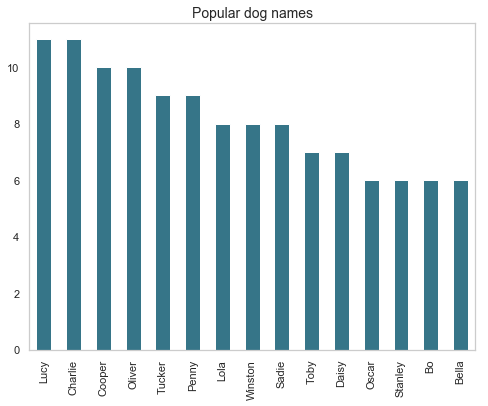

In [143]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8,6))
names = df['name']
names.value_counts().head(15).plot(kind = 'bar', color = "#367588", ax = ax, grid = False)
plt.title('Popular dog names',fontsize=14);

In [144]:
df.name.value_counts()

Lucy         11
Charlie      11
Cooper       10
Oliver       10
Tucker        9
Penny         9
Lola          8
Winston       8
Sadie         8
Toby          7
Daisy         7
Oscar         6
Stanley       6
Bo            6
Bella         6
Jax           6
Koda          6
Bailey        6
Rusty         5
Milo          5
Scout         5
Chester       5
Leo           5
Bentley       5
Buddy         5
Louis         5
Duke          4
Clark         4
Winnie        4
Gary          4
             ..
Brandi        1
Sprout        1
Charleson     1
Divine        1
Billy         1
Chevy         1
Lenox         1
Shelby        1
Keurig        1
Florence      1
Tilly         1
Astrid        1
Scruffers     1
Napolean      1
Baloo         1
Griswold      1
Arya          1
Nico          1
Flash         1
Dutch         1
Cedrick       1
Ralpher       1
Rambo         1
Beckham       1
Zeus          1
Kota          1
Rorie         1
Herb          1
Smiley        1
Strider       1
Name: name, Length: 914,

The most popular dog names are Charlie and Lucy, followed by Oliver and Cooper. Since only one of the names is a female name, we can conclude that the majority of popular names are predominant in male dogs, however sometimes owners find the gender later and therefor might have mistakenly or intentionaly named their female dog also a popular male dog name. 

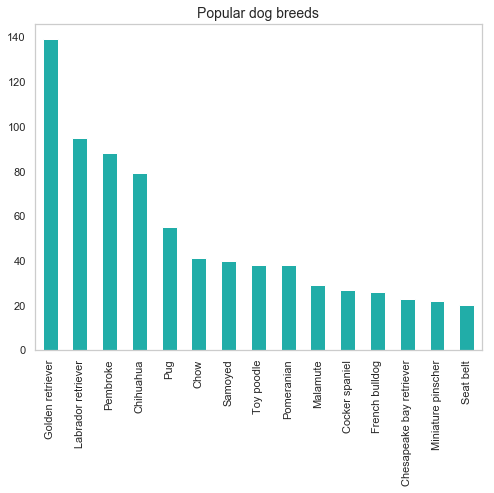

In [145]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8,6))
names = df['p1']
names.value_counts().head(15).plot(kind = 'bar', color = "#21ada8", ax = ax, grid = False)
plt.title('Popular dog breeds',fontsize=14);

The most popular breed is Golder retriever, which was expected since it is globally a loved breed considering their pleasent appearance and intelligence. 

In [146]:
df.query('p1=="Golden retriever" and name == "Lucy"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,retweeted,just_date
1124,705970349788291072,2016-05-11 01:44:07+00:00,Twitter for iPhone,This is Lucy. She's a Venetian Kerploof. Suppo...,https://twitter.com/dog_rates/status/705970349...,12.0,10.0,Lucy,NaN,https://pbs.twimg.com/media/CcwcSS9WwAALE4f.jpg,...,Labrador retriever,0.112413,True,Chow,0.036953,True,3241,928,False,2016-05-11
1160,702684942141153280,2016-04-23 22:38:43+00:00,Twitter for iPhone,This is Lucy. She's sick of these bullshit gen...,https://twitter.com/dog_rates/status/702684942...,11.0,10.0,Lucy,NaN,https://pbs.twimg.com/media/CcBwOn0XEAA7bNQ.jpg,...,Chesapeake bay retriever,0.173224,True,Brittany spaniel,0.118384,True,3334,1130,False,2016-04-23


In [147]:
df.text[1160]

"This is Lucy. She's sick of these bullshit generalizations 11/10 https://t.co/d2b5C2R0aO"

### 2. Is there any correlation between tweets marked as favourite, tweets retweeted and the ratings received?

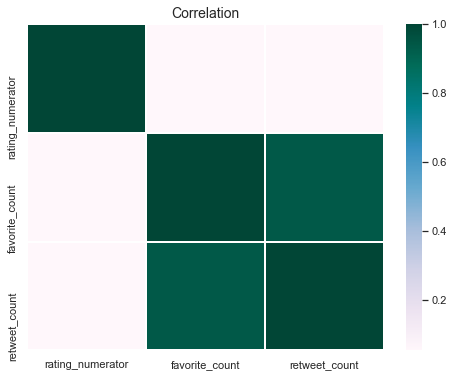

In [148]:
# Create new dataframe for the correlation values
df_correlation = df[['rating_numerator', 'favorite_count', 'retweet_count']]

# Draw a heatmap
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_correlation.corr(), linewidths=1, ax=ax, cmap="PuBuGn")
plt.title('Correlation',fontsize=14);

In [149]:
df_correlation.corr()

,rating_numerator,favorite_count,retweet_count
rating_numerator,1.000000,0.054558,0.052926
favorite_count,0.054558,1.000000,0.937573
retweet_count,0.052926,0.937573,1.000000


There is no correlation between the ratings and the number of times a tweet was marked as favourite or retweeted, however we can see that there is a strong correlation between the favourite and retweeted count, which was expected. 

### 3. Which are the most common stages the dogs are in? How do they compare in terms of ratings received?

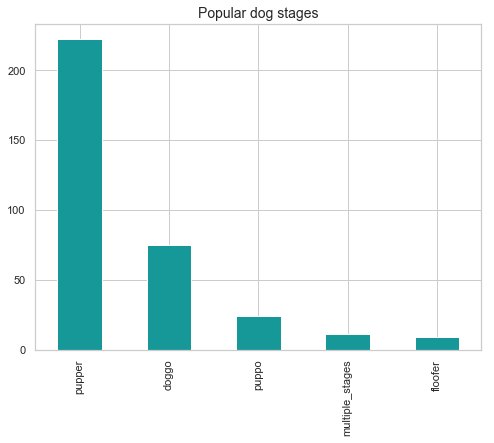

In [150]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 6))
names = df.stage
names.value_counts().plot(kind = 'bar', ax=ax, color = "#159897")
plt.title('Popular dog stages',fontsize=14)
plt.show();

The most popular tweets contain images of a pupper, which according to the Dogtionary means "a small doggo, usually younger". This was also as expected as younger and smaller dogs receive more attention and therefor more pictures.

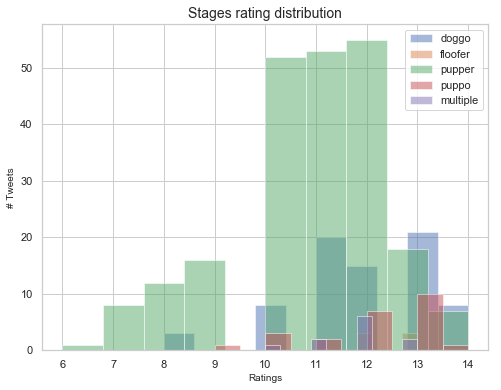

In [151]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 6))
df[df.stage == 'doggo']['rating_numerator'].hist(alpha=.5, label = 'doggo')
df[df.stage == 'floofer']['rating_numerator'].hist(alpha=.5, label = 'floofer')
df[df.stage == 'pupper']['rating_numerator'].hist(alpha=.5, label = 'pupper')
df[df.stage == 'puppo']['rating_numerator'].hist(alpha=.5, label = 'puppo')
df[df.stage == 'multiple_stages']['rating_numerator'].hist(alpha=.5, label = 'multiple')
plt.legend()
plt.title('Stages rating distribution',fontsize=14)
plt.xlabel('Ratings', fontsize=10)
plt.ylabel('# Tweets', fontsize=10);

As visualized before, pupper has the clear leading position in terms of number of tweets, while doggo seems to be ahead by highest ratings.

### 4. How did the rating changed in time, do newer tweets receive better ratings?

In [152]:
# Check for outliers
df.query('rating_numerator > 50')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,retweeted,just_date
162,855862651834028032,2017-05-05 16:00:04+00:00,Twitter for iPhone,@dhmontgomery We also gave snoop dogg a 420/10...,NaN,420.0,10.0,NaN,NaN,NaN,...,NaN,NaN,True,NaN,NaN,True,0,0,True,2017-05-05
163,855860136149123072,2017-05-04 23:34:55+00:00,Twitter for iPhone,@s8n You tried very hard to portray this good ...,NaN,666.0,10.0,NaN,NaN,NaN,...,NaN,NaN,True,NaN,NaN,True,5021,1041,False,2017-05-04
246,838150277551247360,2017-03-25 16:45:08+00:00,Twitter for iPhone,@markhoppus 182/10,NaN,182.0,10.0,NaN,NaN,NaN,...,NaN,NaN,True,NaN,NaN,True,1737,352,False,2017-03-25
793,749981277374128128,2016-09-07 15:44:53+00:00,Twitter for iPhone,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776.0,10.0,Atticus,NaN,NaN,...,NaN,NaN,True,NaN,NaN,True,5312,2600,False,2016-09-07
1818,670842764863651840,2015-12-15 02:43:33+00:00,Twitter for iPhone,After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420.0,10.0,NaN,NaN,NaN,...,NaN,NaN,True,NaN,NaN,True,24610,8818,False,2015-12-15


In [153]:
# Remove outliers
df.drop(df.query('rating_numerator > 50').index, inplace = True)
df.drop(df.query('rating_numerator == 0').index, inplace = True)

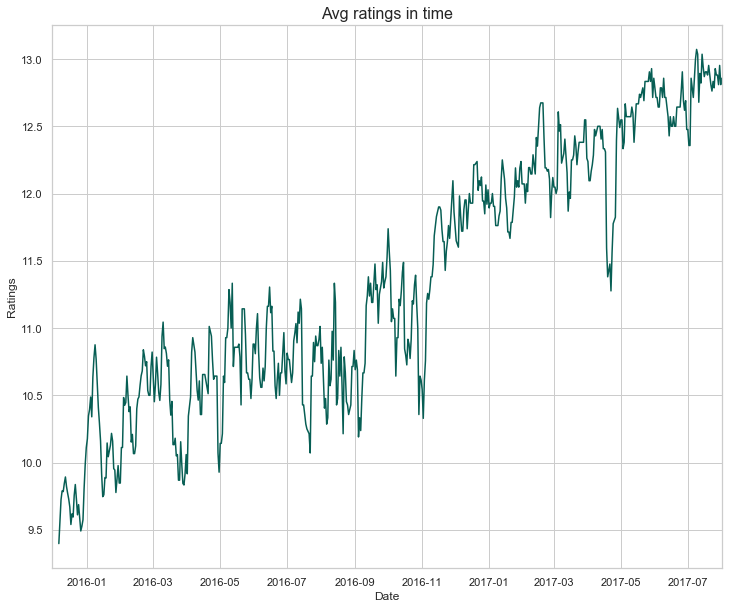

In [154]:
plt.subplots(figsize=(12,10))
df.groupby(df['just_date']).mean()['rating_numerator'].rolling(window=7).mean().plot(kind = 'line', color = "#075E54")
plt.title('Avg ratings in time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Ratings', fontsize=12);

Calculating the rolling average of the ratings in time, we can see a clear growing tendence, so the overall ratings have improved in the most recent months.